In [1]:
import torch
from torch.autograd import Variable
import DLEDMD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Get data, 所有数据的第0号作为训练数据，其余作为测试数据

In [6]:
data = np.load('./databygroup.npy',allow_pickle=True).tolist()
TrainData,TestData={},{}
for k in data.keys():
    if ('historydata' in k):
        TrainData[k]=data[k]
    TestData[k]=data[k]

# 一个HRT内的所有数据
HRT_step = 10
k = 'historydata'
xtrain,ytrain=TrainData[k][0:-2,0:TrainData[k].shape[1]-5],TrainData[k][1:-1,[-5,-4,-3,-2,-1]]
xtrain = Variable(torch.FloatTensor(xtrain))
ytrain = Variable(torch.FloatTensor(ytrain))
print(xtrain.shape,ytrain.shape)

torch.Size([19998, 15]) torch.Size([19998, 5])


# Koopman DLEDMD

## 训练

In [7]:
# 在不同文件夹内创建保存Koopman分析结果的文件夹

for k in TestData.keys():
    if os.path.exists('./DLEDMD_model/'+k):
        pass
    else:
        os.makedirs('./DLEDMD_model/'+k)

if os.path.exists('./DLEDMD_model/traindata'):
    pass
else:
    os.makedirs('./DLEDMD_model/traindata')

for d in TestData.keys():
    if not os.path.exists('./results/'+d):
        #if '.csv0' not in d:
        os.makedirs('./results/'+d)
    
    os.chdir(os.path.pardir)
    if not os.path.exists('./Step3_dataselect/results_s/'+d):
        #if '.csv0' not in d:
        os.makedirs('./Step3_dataselect/results_s/'+d)
    os.chdir('./Step2_Koopman')
        
   
if not os.path.exists('./results/traindata'):
    os.makedirs('./results/traindata')
os.chdir(os.path.pardir)
if not os.path.exists('./Step3_dataselect/results_s/traindata'):
    os.makedirs('./Step3_dataselect/results_s/traindata')
os.chdir('./Step2_Koopman')

c:\Users\chong\Desktop\Koopman_WQ\Step2_Koopman


C:\Users\chong\AppData\Local\Temp\ipykernel_18248\3242083404.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.model = torch.load('./DLEDMD_model/kmodel')


c:\Users\chong\Desktop\Koopman_WQ


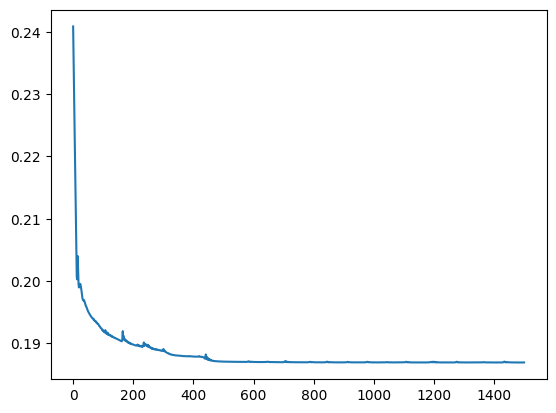

In [10]:
param={
        'X_size':xtrain.shape[1], 
        'Y_size':ytrain.shape[1], 
        'batch_size':xtrain.shape[0],
        'feature_size':100,
        'Xencodering_layer':[100 for _ in range(4)],
        'Yencodering_layer':[100 for _ in range(4)],
        'decodering_layer':[100 for _ in range(4)],
        'output_dim':ytrain.shape[1], 
        'learning_rate':0.001,
        'opt':'Adam',
    }
train = True
initial_train = True

print(os.getcwd())

net = DLEDMD.Net(param)

if train:
    optimizer = torch.optim.Adam(net.parameters(),lr = param['learning_rate'])
    loss_func = torch.nn.MSELoss()
    if initial_train:
        net.model = torch.load('./DLEDMD_model/kmodel')
    mse=[]
    for t in range(1500):
        output = net(xtrain,ytrain)
        loss = loss_func(output,ytrain)
        mse.append(loss.detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    torch.save(net,'./DLEDMD_model/kmodel')

    K = net.Ku.detach().numpy()
    U,s,V=np.linalg.svd(K)
    np.save('./results/traindata/U.npy',U)
    np.save('./results/traindata/V.npy',V)
    np.save('./results/traindata/s.npy',s)
    np.save('./results/traindata/K.npy',K)
    os.chdir(os.path.pardir)
    print(os.getcwd())
    np.save('./Step3_dataselect/results_s/traindata/U.npy',U)
    np.save('./Step3_dataselect/results_s/traindata/V.npy',V)
    np.save('./Step3_dataselect/results_s/traindata/s.npy',s)
    np.save('./Step3_dataselect/results_s/traindata/K.npy',K)
    os.chdir('./Step2_Koopman')
    plt.plot(mse)
    np.save('./mse.npy',mse)
else:
    net.model = torch.load('./DLEDMD_model/kmodel')


In [12]:
# Calculate eigenvalues of all subdataset
for k in TestData.keys():
    xtest = Variable(torch.FloatTensor(TestData[k][:-2,0:TestData[k].shape[1]-5]))
    ytest = Variable(torch.FloatTensor(TestData[k][1:-1,[-5,-4,-3,-2,-1]]))
    print(xtest.shape)
    print(k)
    out = net(xtest,ytest)
    K = net.Ku.detach().numpy()
    U,s,V=np.linalg.svd(K)
    np.save('./results/'+k+'/U.npy',U)
    np.save('./results/'+k+'/V.npy',V)
    np.save('./results/'+k+'/s.npy',s)
    np.save('./results/'+k+'/K.npy',K)
    
    
    os.chdir(os.path.pardir)
    print(os.getcwd())
    np.save('./Step3_dataselect/results_s/'+k+'/U.npy',U)
    np.save('./Step3_dataselect/results_s/'+k+'/V.npy',V)
    np.save('./Step3_dataselect/results_s/'+k+'/s.npy',s)
    np.save('./Step3_dataselect/results_s/'+k+'/K.npy',K)
    os.chdir('./Step2_Koopman')


torch.Size([19998, 15])
historydata
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([400, 15])
sub1
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([444, 15])
sub2
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([380, 15])
sub3
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([335, 15])
sub4
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([440, 15])
sub5
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([454, 15])
sub6
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([462, 15])
sub7
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([317, 15])
sub8
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([417, 15])
sub9
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([306, 15])
sub10
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([480, 15])
sub11
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([356, 15])
sub12
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([453, 15])
sub13
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([464, 15])
sub14
c:\Users\chong\Desktop\Koopman_WQ
torch.Size([415, 15])
sub15
c:\Users\chong\Desktop\Koopman_WQ
torch.Siz